# 최근접 이웃(K-Nearest Neighbor)

* 특별한 예측 모델 없이 가장 가까운 데이터 포인트를 기반으로 예측을 수행하는 방법
* 분류와 회귀 모두 지원

![k nearest neighbor](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)

In [2]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

In [3]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.datasets import load_boston, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline

## K 최근접 이웃 분류

* 입력 데이터 포인트와 가장 가까운 k개의 훈련 데이터 포인트가 출력
* k개의 데이터 포인트 중 가장 많은 클래스가 예측 결과

### 붓꽃 데이터

In [16]:
iris=load_iris()

In [17]:
iris_df=pd.DataFrame(data=iris.data,columns=iris.feature_names)
iris_df['target']= iris.target
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [64]:
X,y = load_iris(return_X_y=True)
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2)

In [65]:
scaler=StandardScaler()
X_train_scale=scaler.fit_transform(X_train)
X_test_scale=scaler.transform(X_test)

In [66]:
model = KNeighborsClassifier()
model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [67]:
print("학습 데이터 점수: {}".format(model.score(X_train,y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test,y_test)))


학습 데이터 점수: 0.9666666666666667
평가 데이터 점수: 1.0


In [68]:
model=KNeighborsClassifier()
model.fit(X_train_scale,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [69]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale,y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test_scale,y_test)))

학습 데이터 점수: 0.975
평가 데이터 점수: 0.9333333333333333


In [24]:
cross_validate(
    estimator= KNeighborsClassifier(),
    X=X,y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.8s finished


{'fit_time': array([0.00082421, 0.00081563, 0.00055885, 0.00058126, 0.00046229]),
 'score_time': array([0.00277257, 0.00286627, 0.00234532, 0.00207853, 0.00191474]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])}

In [25]:
param_grid=[{'n_neighbors':[3,5,7],
             'weights':['uniform','distance'],
             'algorithm':['ball_tree','kd_tree','brute']}]

In [26]:
gs=GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True 
)

In [27]:
gs.fit(X,y)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    0.2s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=2,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [28]:
gs.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [29]:
print('GridSearchCV best Score:{}'.format(gs.best_score_))

GridSearchCV best Score:0.9800000000000001


In [30]:
def make_meshgrid(x,y,h=.02):
  x_min,x_max = x.min()-1,x.max()+1
  y_min,y_max=x.min()-1, y.max()+1
  xx,yy=np.meshgrid(np.arange(x_min,x_max,h),
                    np.arange(y_min,y_max,h))
  return xx, yy

def plot_contour(clf,xx,yy,**params):
  Z=clf.predict(np.c_[xx.ravel(),yy.ravel()])
  Z=Z.reshape(xx.shape)
  out=plt.contour(xx,yy,Z,**params)

  return out


In [31]:
tsne=TSNE(n_components=2)
X_comp=tsne.fit_transform(X)

In [32]:
iris_comp_df=pd.DataFrame(data=X_comp)
iris_comp_df['Target']=y
iris_comp_df

,0,1,Target
0,-5.279422,-26.001707,0
1,-4.641097,-28.690615,0
2,-5.779421,-28.632900,0
3,-5.395024,-29.065149,0
4,-4.873183,-25.969460,0
...,...,...,...
145,-0.121496,18.552288,2
146,0.772130,15.489448,2
147,0.292111,17.717909,2
148,-1.050040,18.700787,2


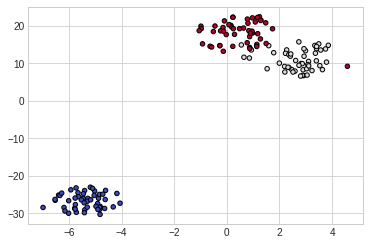

In [33]:
plt.scatter(X_comp[:,0],X_comp[:,1],
            c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')

In [34]:
model=KNeighborsClassifier()
model.fit(X_comp,y)
predict=model.predict(X_comp)

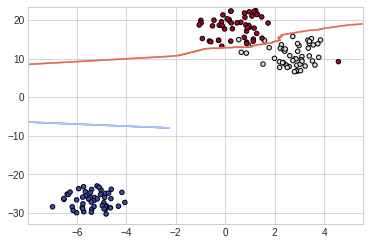

In [35]:
xx,yy=make_meshgrid(X_comp[:,0],X_comp[:,1])
plot_contour(model,xx,yy,cmap=plt.cm.coolwarm,alpha=0.8)
plt.scatter(X_comp[:,0],X_comp[:,1],c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')

### 유방암 데이터

In [71]:
cancer= load_breast_cancer()

In [72]:
cancer_df=pd.DataFrame(data=cancer.data,columns=cancer.feature_names)
cancer_df['taget']=cancer.target
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,taget
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [73]:
X,y=cancer.data,cancer.target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [74]:
cancer_train_df=pd.DataFrame(data=X_train,columns=cancer.feature_names)
cancer_train_df['target']=y_train
cancer_train_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,13.940,13.17,90.31,594.2,0.12480,0.09755,0.10100,0.06615,0.1976,0.06457,0.5461,2.6350,4.091,44.74,0.010040,0.03247,0.04763,0.028530,0.01715,0.005528,14.620,15.38,94.52,653.3,0.1394,0.13640,0.1559,0.10150,0.2160,0.07253,1
1,14.960,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,0.05852,0.2877,0.9480,2.171,24.87,0.005332,0.02115,0.01536,0.011870,0.01522,0.002815,16.250,26.19,109.10,809.8,0.1313,0.30300,0.1804,0.14890,0.2962,0.08472,1
2,17.460,39.28,113.40,920.6,0.09812,0.12980,0.14170,0.08811,0.1809,0.05966,0.5366,0.8561,3.002,49.00,0.004860,0.02785,0.02602,0.013740,0.01226,0.002759,22.510,44.87,141.20,1408.0,0.1365,0.37350,0.3241,0.20660,0.2853,0.08496,0
3,8.597,18.60,54.09,221.2,0.10740,0.05847,0.00000,0.00000,0.2163,0.07359,0.3368,2.7770,2.222,17.81,0.020750,0.01403,0.00000,0.000000,0.06146,0.006820,8.952,22.44,56.65,240.1,0.1347,0.07767,0.0000,0.00000,0.3142,0.08116,1
4,11.600,12.84,74.34,412.6,0.08983,0.07525,0.04196,0.03350,0.1620,0.06582,0.2315,0.5391,1.475,15.75,0.006153,0.01330,0.01693,0.006884,0.01651,0.002551,13.060,17.16,82.96,512.5,0.1431,0.18510,0.1922,0.08449,0.2772,0.08756,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,27.420,26.27,186.90,2501.0,0.10840,0.19880,0.36350,0.16890,0.2061,0.05623,2.5470,1.3060,18.650,542.20,0.007650,0.05374,0.08055,0.025980,0.01697,0.004558,36.040,31.37,251.20,4254.0,0.1357,0.42560,0.6833,0.26250,0.2641,0.07427,0
451,20.480,21.46,132.50,1306.0,0.08355,0.08348,0.09042,0.06022,0.1467,0.05177,0.6874,1.0410,5.144,83.50,0.007959,0.03133,0.04257,0.016710,0.01341,0.003933,24.220,26.17,161.70,1750.0,0.1228,0.23110,0.3158,0.14450,0.2238,0.07127,0
452,16.030,15.51,105.80,793.2,0.09491,0.13710,0.12040,0.07041,0.1782,0.05976,0.3371,0.7476,2.629,33.27,0.005839,0.03245,0.03715,0.014590,0.01467,0.003121,18.760,21.98,124.30,1070.0,0.1435,0.44780,0.4956,0.19810,0.3019,0.09124,0
453,11.890,18.35,77.32,432.2,0.09363,0.11540,0.06636,0.03142,0.1967,0.06314,0.2963,1.5630,2.087,21.46,0.008872,0.04192,0.05946,0.017850,0.02793,0.004775,13.250,27.10,86.20,531.2,0.1405,0.30460,0.2806,0.11380,0.3397,0.08365,1


In [75]:
cancer_test_df=pd.DataFrame(data=X_test,columns=cancer.feature_names)
cancer_test_df['target']=y_test
cancer_test_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,18.310,20.58,120.80,1052.0,0.10680,0.12480,0.156900,0.094510,0.1860,0.05941,0.5449,0.9225,3.2180,67.360,0.006176,0.018770,0.029130,0.010460,0.01559,0.002725,21.860,26.20,142.20,1493.0,0.1492,0.25360,0.37590,0.15100,0.3074,0.07863,0
1,15.040,16.74,98.73,689.4,0.09883,0.13640,0.077210,0.061420,0.1668,0.06869,0.3720,0.8423,2.3040,34.840,0.004123,0.018190,0.019960,0.010040,0.01055,0.003237,16.760,20.43,109.70,856.9,0.1135,0.21760,0.18560,0.10180,0.2177,0.08549,1
2,13.050,13.84,82.71,530.6,0.08352,0.03735,0.004559,0.008829,0.1453,0.05518,0.3975,0.8285,2.5670,33.010,0.004148,0.004711,0.002831,0.004821,0.01422,0.002273,14.730,17.40,93.96,672.4,0.1016,0.05847,0.01824,0.03532,0.2107,0.06580,1
3,8.726,15.83,55.84,230.9,0.11500,0.08201,0.041320,0.019240,0.1649,0.07633,0.1665,0.5864,1.3540,8.966,0.008261,0.022130,0.032590,0.010400,0.01708,0.003806,9.628,19.62,64.48,284.4,0.1724,0.23640,0.24560,0.10500,0.2926,0.10170,1
4,12.220,20.04,79.47,453.1,0.10960,0.11520,0.081750,0.021660,0.2124,0.06894,0.1811,0.7959,0.9857,12.580,0.006272,0.021980,0.039660,0.009894,0.01320,0.003813,13.160,24.17,85.13,515.3,0.1402,0.23150,0.35350,0.08088,0.2709,0.08839,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,19.730,19.82,130.70,1206.0,0.10620,0.18490,0.241700,0.097400,0.1733,0.06697,0.7661,0.7800,4.1150,92.810,0.008482,0.050570,0.068000,0.019710,0.01467,0.007259,25.280,25.59,159.80,1933.0,0.1710,0.59550,0.84890,0.25070,0.2749,0.12970,0
110,16.070,19.65,104.10,817.7,0.09168,0.08424,0.097690,0.066380,0.1798,0.05391,0.7474,1.0160,5.0290,79.250,0.010820,0.022030,0.035000,0.018090,0.01550,0.001948,19.770,24.56,128.80,1223.0,0.1500,0.20450,0.28290,0.15200,0.2650,0.06387,0
111,12.210,14.09,78.78,462.0,0.08108,0.07823,0.068390,0.025340,0.1646,0.06154,0.2666,0.8309,2.0970,19.960,0.004405,0.030260,0.043440,0.010870,0.01921,0.004622,13.130,19.29,87.65,529.9,0.1026,0.24310,0.30760,0.09140,0.2677,0.08824,1
112,24.630,21.60,165.50,1841.0,0.10300,0.21060,0.231000,0.147100,0.1991,0.06739,0.9915,0.9004,7.0500,139.900,0.004989,0.032120,0.035710,0.015970,0.01879,0.004760,29.920,26.93,205.70,2642.0,0.1342,0.41880,0.46580,0.24750,0.3157,0.09671,0


In [76]:
scaler=StandardScaler()
X_train_scale=scaler.fit_transform(X_train)
X_test_scale=scaler.transform(X_test)

In [77]:
model=KNeighborsClassifier()
model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [78]:
print("학습 데이터 점수: {}".format(model.score(X_train,y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test,y_test)))

학습 데이터 점수: 0.945054945054945
평가 데이터 점수: 0.9122807017543859


In [79]:
model=KNeighborsClassifier()
model.fit(X_train_scale,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [80]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale,y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test_scale,y_test)))


학습 데이터 점수: 0.978021978021978
평가 데이터 점수: 0.9824561403508771


In [81]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [82]:
cross_validate(
    estimator=estimator,
    X=X,y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.7s finished


{'fit_time': array([0.00285673, 0.0030179 , 0.00217676, 0.00268197, 0.00234914]),
 'score_time': array([0.0105679 , 0.01084685, 0.01119566, 0.00979352, 0.00733328]),
 'test_score': array([0.96491228, 0.95614035, 0.98245614, 0.95614035, 0.96460177])}

In [83]:
pipe=Pipeline(
    [('scaler',StandardScaler()),
     ('model',KNeighborsClassifier())]
)


In [49]:
param_grid=[{'model__n_neighbors':[3,5,7],
             'model__weights':['uniform','distance'],
             'model__algorithm':['ball_tree','kd_tree','brute']}]


In [50]:
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [51]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    0.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
      

In [52]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=7, p=2,
                                      weights='uniform'))],
         verbose=False)

In [53]:
print("GridSearchCV test score:{}".format(gs.best_score_))

GridSearchCV test score:0.9701288619779538


In [54]:
tsne=TSNE(n_components=2)
X_comp=tsne.fit_transform(X)

In [55]:
cancer_comp_df = pd.DataFrame(data=X_comp)
cancer_comp_df['target']=y
cancer_comp_df

,0,1,target
0,-30.243711,-12.313796,0
1,-30.316633,-15.203541,0
2,-25.363358,-15.853263,0
3,7.763040,16.411909,0
4,-24.405241,-18.139902,0
...,...,...,...
564,-32.023788,-15.751148,0
565,-26.459309,-16.380608,0
566,-6.983279,-18.979702,0
567,-28.025835,-15.344255,0


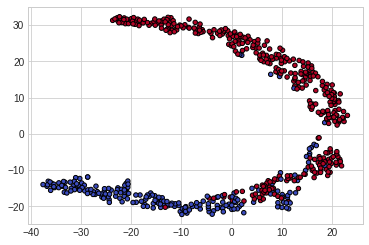

In [56]:
plt.scatter(X_comp[:,0],X_comp[:,1],c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')

In [57]:
model=KNeighborsClassifier()
model.fit(X_comp,y)
predict=model.predict(X_comp)

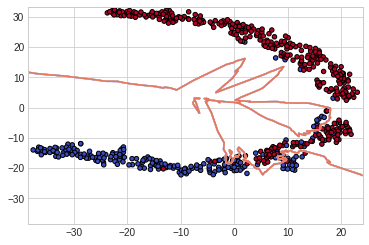

In [58]:
xx,yy=make_meshgrid(X_comp[:,0],X_comp[:,1])
plot_contour(model,xx,yy,cmap=plt.cm.coolwarm,alpha=0.8)
plt.scatter(X_comp[:,0],X_comp[:,1],c=y,cmap=plt.cm.coolwarm,s=20,edgecolors='k')

## k 최근접 이웃 회귀

* k 최근접 이웃 분류와 마찬가지로 예측에 이웃 데이터 포인트 사용
* 이웃 데이터 포인트의 평균이 예측 결과

### 보스턴 주택 가격 데이터

In [88]:
boston=load_boston()

In [89]:
boston_df=pd.DataFrame(data=boston.data,columns=boston.feature_names)
boston_df['target']=boston.target

In [90]:
X,y =boston.data,boston.target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [91]:
boston_train_df = pd.DataFrame(data=X_train,columns=boston.feature_names)
boston_train_df['target']=y_train


In [93]:
boston_test_df = pd.DataFrame(data=X_test,columns=boston.feature_names)
boston_test_df['target']=y_test


In [95]:
scaler=StandardScaler()
X_train_scale=scaler.fit_transform(X_train)
X_test_scale=scaler.transform(X_test)

In [97]:
model = KNeighborsRegressor()
model.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [98]:
print('학습 데이터 점수: {}'.format(model.score(X_train,y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test,y_test)))


학습 데이터 점수: 0.6924745654156179
평가 데이터 점수: 0.5206955554028436


In [99]:
model=KNeighborsRegressor()
model.fit(X_train_scale,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [100]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale,y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test_scale,y_test)))


학습 데이터 점수: 0.826799240498511
평가 데이터 점수: 0.7121408062430583


In [101]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

In [102]:
cross_validate(
    estimator=estimator,
    X=X,y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.7s finished


{'fit_time': array([0.00214744, 0.00184107, 0.00151348, 0.00157881, 0.00143409]),
 'score_time': array([0.00278473, 0.00247741, 0.00200486, 0.00210071, 0.00196648]),
 'test_score': array([0.56089547, 0.61917359, 0.48661916, 0.46986886, 0.23133037])}

In [103]:
pipe=Pipeline(
    [('scaler',StandardScaler()),
     ('model',KNeighborsRegressor())]
)


In [104]:
param_grid=[{'model__n_neighbors':[3,5,7],
             'model__weights':['uniform','distance'],
             'model__algorithm':['ball_tree','kd_tree','brute']}]


In [105]:
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [106]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    0.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
             

In [107]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=7, p=2,
                                     weights='distance'))],
         verbose=False)

In [108]:
print("GridSearchCV test score:{}".format(gs.best_score_))

GridSearchCV test score:0.4973060611762845


In [112]:
tsne=TSNE(n_components=1)
X_comp=tsne.fit_transform(X)

In [113]:
boston_comp_df = pd.DataFrame(data=X_comp)
boston_comp_df['target']=y
boston_comp_df

,0,target
0,22.767921,24.0
1,41.664028,21.6
2,38.843193,34.7
3,38.362812,33.4
4,38.962368,36.2
...,...,...
501,24.972609,22.4
502,-52.016754,20.6
503,26.311432,23.9
504,26.278109,22.0


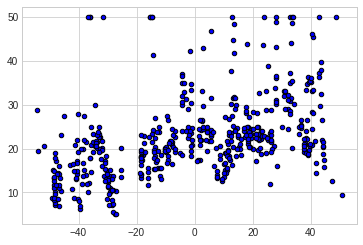

In [115]:
plt.scatter(X_comp,y,c='b',cmap=plt.cm.coolwarm,s=20,edgecolors='k')

In [116]:
model=KNeighborsRegressor()
model.fit(X_comp,y)
predict=model.predict(X_comp)

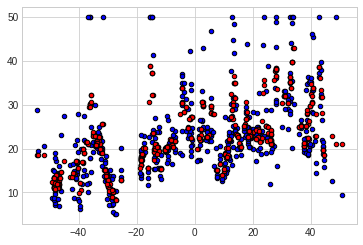

In [117]:
plt.scatter(X_comp,y,c='b',cmap=plt.cm.coolwarm,s=20,edgecolors='k')
plt.scatter(X_comp,predict,c='r',cmap=plt.cm.coolwarm,s=20,edgecolors='k')

### 캘리포니아 주택 가격 데이터

In [4]:
california=fetch_california_housing()

In [6]:
california_df=pd.DataFrame(data=california.data,columns=california.feature_names)
california_df['target']=california.target
california_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [7]:
X,y =california.data,california.target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [9]:
california_train_df = pd.DataFrame(data=X_train,columns=california.feature_names)
california_train_df['target']=y_train
california_train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,1.9402,43.0,2.819071,1.004890,1667.0,4.075795,34.05,-118.22,1.39300
1,3.2667,17.0,6.225331,1.073638,1809.0,2.664212,37.82,-120.79,2.69500
2,3.3074,34.0,5.715789,0.984211,663.0,3.489474,38.68,-121.37,0.84200
3,1.9063,52.0,3.603399,0.912181,984.0,2.787535,34.09,-118.29,2.61600
4,1.7207,40.0,3.065681,1.039409,2223.0,3.650246,33.98,-118.25,1.05100
...,...,...,...,...,...,...,...,...,...
16507,2.1250,39.0,3.358407,0.951327,883.0,3.907080,34.02,-118.17,1.43800
16508,2.4884,43.0,4.202322,0.981758,2448.0,4.059701,36.68,-121.62,1.30500
16509,4.1587,32.0,5.580808,1.075758,1082.0,2.732323,37.00,-121.94,3.15200
16510,15.0001,40.0,8.584541,1.000000,577.0,2.787440,37.46,-122.21,5.00001


In [11]:
california_test_df = pd.DataFrame(data=X_test,columns=california.feature_names)
california_test_df['target']=y_test
california_test_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,3.6583,13.0,6.309711,1.112861,2568.0,3.370079,38.52,-122.85,1.832
1,3.4605,49.0,4.044156,1.051948,1173.0,3.046753,37.72,-122.44,2.650
2,4.1797,25.0,4.786408,1.016181,977.0,3.161812,34.44,-119.79,2.718
3,2.8994,34.0,5.295209,0.962906,1938.0,2.995363,36.80,-119.78,0.660
4,2.9688,42.0,4.162544,0.922261,804.0,2.840989,33.99,-117.36,0.929
...,...,...,...,...,...,...,...,...,...
4123,5.3994,23.0,5.019157,1.022989,910.0,3.486590,37.44,-121.88,2.379
4124,7.3521,32.0,6.775758,1.054545,818.0,2.478788,37.99,-122.54,4.440
4125,2.9934,35.0,3.349425,1.073563,1334.0,1.533333,34.02,-118.50,3.500
4126,2.2569,20.0,5.604000,1.120000,668.0,2.672000,39.74,-122.13,0.943


In [12]:
scaler=StandardScaler()
X_train_scale=scaler.fit_transform(X_train)
X_test_scale=scaler.transform(X_test)

In [13]:
model = KNeighborsRegressor()
model.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [14]:
print('학습 데이터 점수: {}'.format(model.score(X_train,y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test,y_test)))


학습 데이터 점수: 0.4485598592533385
평가 데이터 점수: 0.16073720655725876


In [15]:
model=KNeighborsRegressor()
model.fit(X_train_scale,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [16]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale,y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test_scale,y_test)))


학습 데이터 점수: 0.8201903082664136
평가 데이터 점수: 0.7537433457682932


In [17]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

In [18]:
cross_validate(
    estimator=estimator,
    X=X,y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.0s finished


{'fit_time': array([0.03048587, 0.03191876, 0.02957535, 0.02886486, 0.02983832]),
 'score_time': array([0.47949743, 0.39069581, 0.4034524 , 0.48096466, 0.31372166]),
 'test_score': array([0.47879396, 0.4760079 , 0.57624554, 0.50259828, 0.57228584])}

In [19]:
pipe=Pipeline(
    [('scaler',StandardScaler()),
     ('model',KNeighborsRegressor())]
)


In [20]:
param_grid=[{'model__n_neighbors':[3,5,7],
             'model__weights':['uniform','distance'],
             'model__algorithm':['ball_tree','kd_tree','brute']}]


In [21]:
gs=GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [22]:
gs.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   19.7s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:   50.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
             

In [23]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=7, p=2,
                                     weights='distance'))],
         verbose=False)

In [24]:
print("GridSearchCV test score:{}".format(gs.best_score_))

GridSearchCV test score:0.5376515274379832


In [25]:
tsne=TSNE(n_components=1)
X_comp=tsne.fit_transform(X)

In [26]:
california_comp_df = pd.DataFrame(data=X_comp)
california_comp_df['target']=y
california_comp_df

,0,target
0,65.430832,4.526
1,71.839371,3.585
2,-4.211607,3.521
3,-8.543118,3.413
4,-14.112520,3.422
...,...,...
20635,12.138095,0.781
20636,63.549049,0.771
20637,39.469902,0.923
20638,-34.635986,0.847


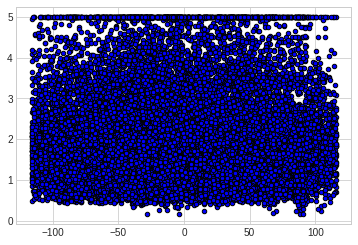

In [27]:
plt.scatter(X_comp,y,c='b',cmap=plt.cm.coolwarm,s=20,edgecolors='k')

In [28]:
model=KNeighborsRegressor()
model.fit(X_comp,y)
predict=model.predict(X_comp)

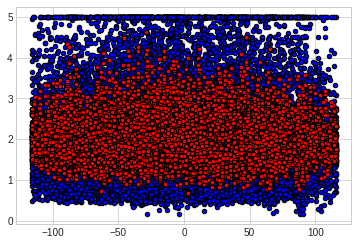

In [29]:
plt.scatter(X_comp,y,c='b',cmap=plt.cm.coolwarm,s=20,edgecolors='k')
plt.scatter(X_comp,predict,c='r',cmap=plt.cm.coolwarm,s=20,edgecolors='k')